In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('AAPL.csv')
print("Data has been loaded")

Data has been loaded


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
print("\nData Overview:")
print(df.head())


Data Overview:
        Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100


In [5]:
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2011 non-null   datetime64[ns]
 1   Open       2011 non-null   float64       
 2   High       2011 non-null   float64       
 3   Low        2011 non-null   float64       
 4   Close      2011 non-null   float64       
 5   Adj Close  2011 non-null   float64       
 6   Volume     2011 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 110.1 KB
None


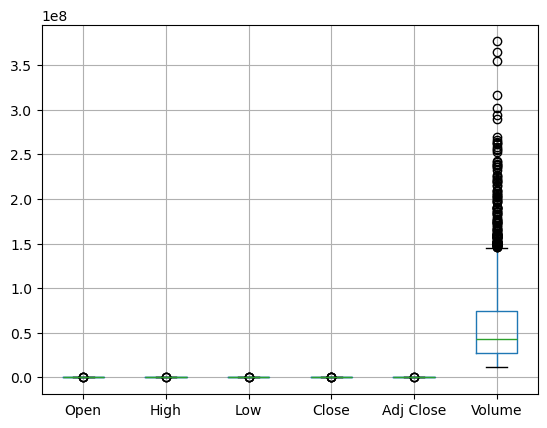

In [6]:
df.boxplot()
plt.show()

In [7]:
def outlier_capping(df,column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR=Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    df[column]= df[column].apply(lambda x: lower_bound if x<lower_bound else upper_bound if x>upper_bound else x)
for col in df.select_dtypes(['int','float']).columns:
    outlier_capping(df,col)

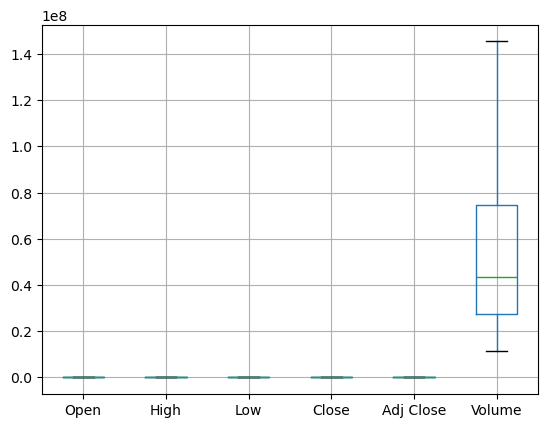

In [8]:
df.boxplot()
plt.show()

In [9]:
df.ffill(inplace=True)
df.bfill(inplace=True)

In [10]:
price_cols = ['Open', 'High', 'Low', 'Close']
scaler = MinMaxScaler()
df[price_cols] = scaler.fit_transform(df[price_cols])
print("\n Missing values handled and price data normalized.")


 Missing values handled and price data normalized.


In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("Preprocessing complete.")

Preprocessing complete.


In [12]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                                Date         Open         High          Low  \
count                           2011  2011.000000  2011.000000  2011.000000   
mean   2016-01-01 03:10:28.344107520     0.311623     0.305738     0.312252   
min              2012-01-03 00:00:00     0.000000     0.000000     0.000000   
25%              2014-01-02 12:00:00     0.133166     0.128077     0.132951   
50%              2015-12-31 00:00:00     0.251942     0.246817     0.251615   
75%              2017-12-28 12:00:00     0.479900     0.476846     0.479771   
max              2019-12-30 00:00:00     1.000000     1.000000     1.000000   
std                              NaN     0.220624     0.220037     0.221709   

             Close    Adj Close        Volume  
count  2011.000000  2011.000000  2.011000e+03  
mean      0.311119   119.504224  5.652610e+07  
min       0.000000    48.921928  1.136200e+07  
25%       0.133375    75.056679  2.758565e+07  
50%       0.251119   105.22

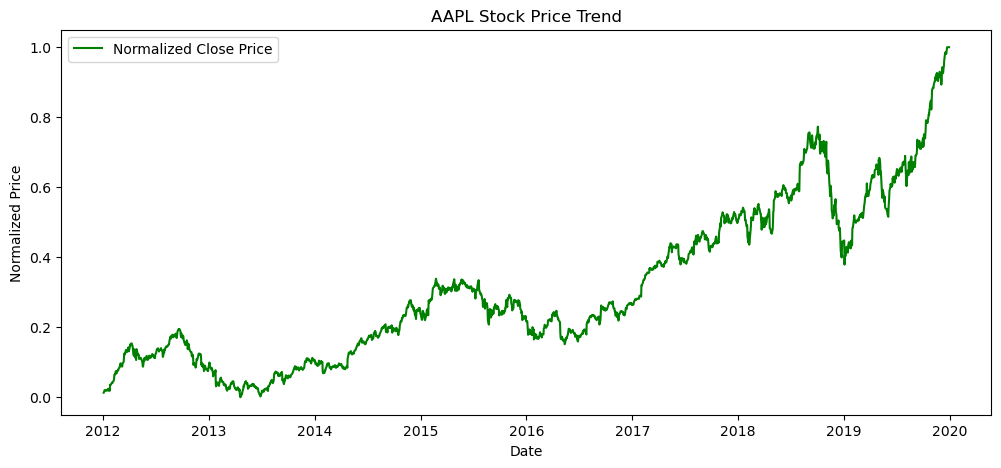

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Normalized Close Price', color='GREEN')
plt.title("AAPL Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

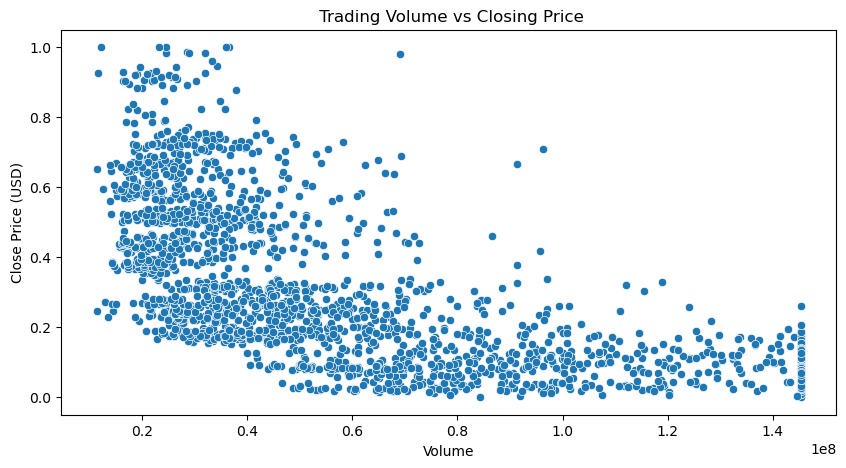

In [14]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['Volume'], y=df['Close'])
plt.title(" Trading Volume vs Closing Price")
plt.xlabel("Volume")
plt.ylabel("Close Price (USD)")
plt.show()

In [15]:
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()

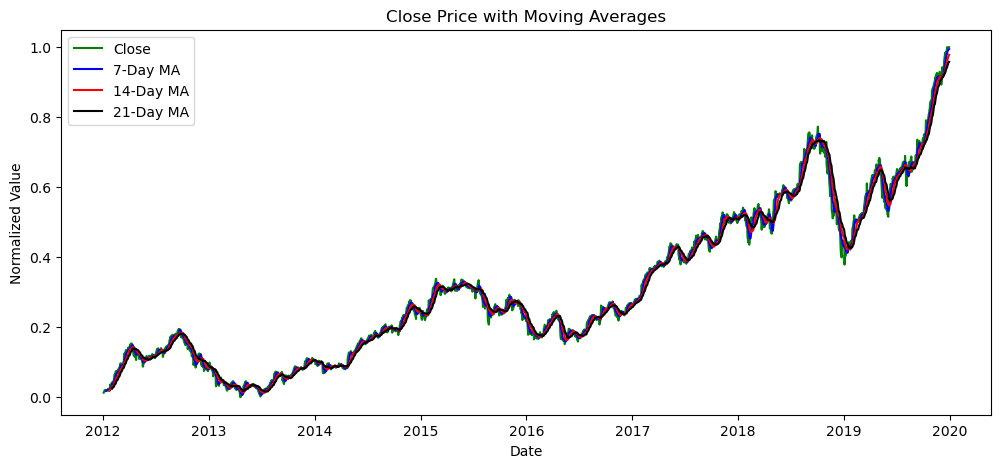

In [16]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close',color='GREEN')
plt.plot(df['Date'], df['MA_7'], label='7-Day MA',color='blue')
plt.plot(df['Date'], df['MA_14'], label='14-Day MA',color='RED')
plt.plot(df['Date'], df['MA_21'], label='21-Day MA',color='black')
plt.title("Close Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

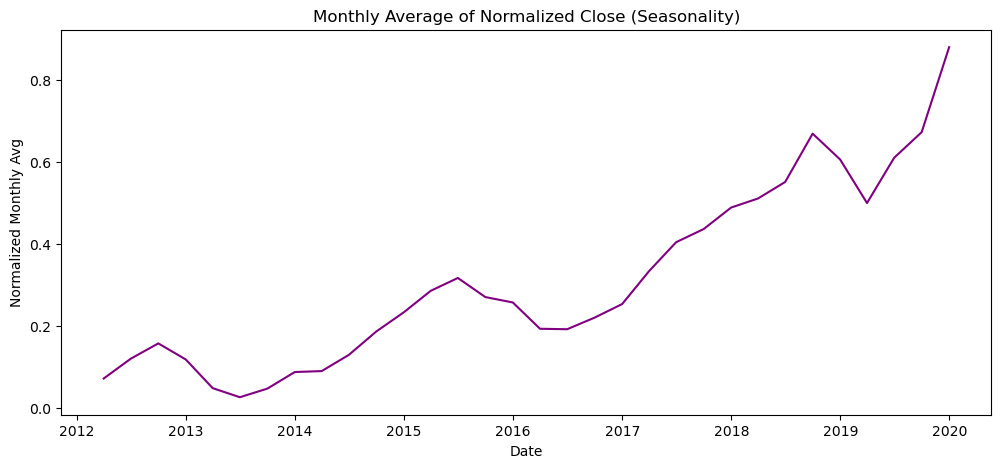

In [17]:
df_monthly = df.set_index('Date').resample('Q').mean()
plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly['Close'], color='purple')
plt.title("Monthly Average of Normalized Close (Seasonality)")
plt.xlabel("Date")
plt.ylabel("Normalized Monthly Avg")
plt.show()

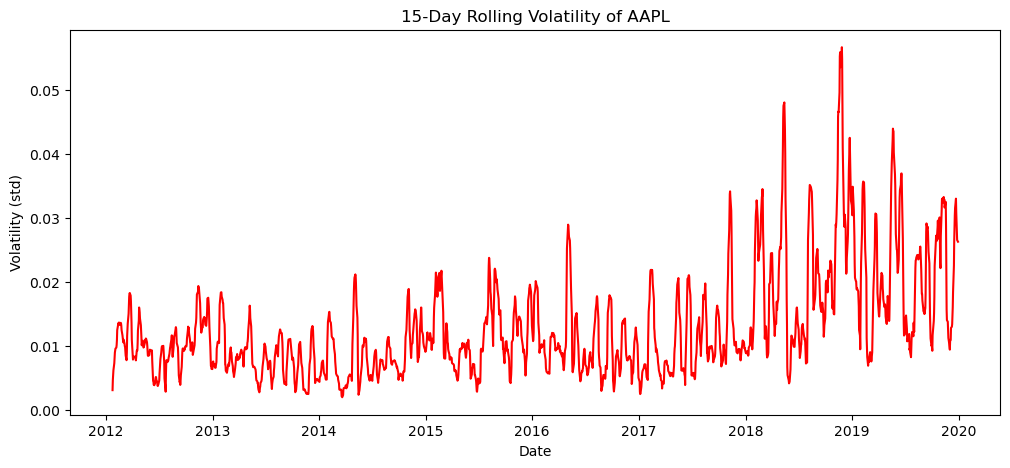

In [18]:
df['Volatility_15'] = df['Close'].rolling(window=15).std() 
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Volatility_15'], color='red')
plt.title("15-Day Rolling Volatility of AAPL")
plt.xlabel("Date")
plt.ylabel("Volatility (std)")
plt.show()

In [19]:
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()
df['Volatility_15'] = df['Close'].rolling(window=15).std()

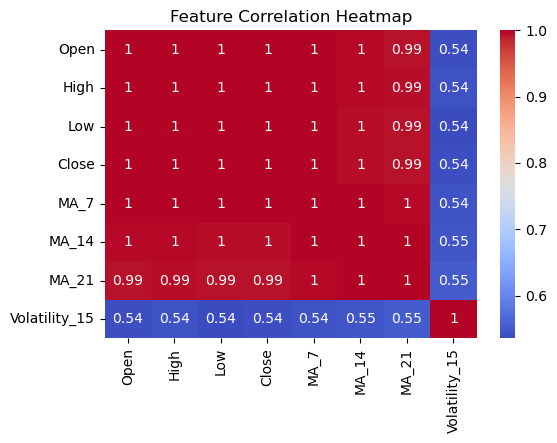

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Open','High','Low','Close','MA_7','MA_14','MA_21','Volatility_15']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [21]:
df[price_cols] = scaler.inverse_transform(df[price_cols])

In [ ]:
df.to_csv("Processed_AAPL.csv", index=False)
print("\n Final processed dataset saved as 'Processed_AAPL.csv'.")


 Final processed dataset saved as 'Processed_AAPL.csv'.


In [23]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60  
X, y = create_sequences(scaled_data, look_back)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

Shape of X (features): (1951, 60)
Shape of y (target): (1951,)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y):]

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from sklearn.metrics import mean_squared_error

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

def calculate_percentage_accuracy(y_true, y_pred, tolerance_percent=5):
    percentage_error = np.abs((y_true - y_pred) / y_true) * 100
    correct_predictions = np.sum(percentage_error <= tolerance_percent)
    accuracy = (correct_predictions / len(y_true)) * 100
    return accuracy

train_accuracy = calculate_percentage_accuracy(y_train_inverse, train_predict)
test_accuracy = calculate_percentage_accuracy(y_test_inverse, test_predict)

print(f'Train Accuracy (within 5% tolerance): {train_accuracy:.2f}%')
print(f'Test Accuracy (within 5% tolerance): {test_accuracy:.2f}%')

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0063 - val_loss: 0.0013
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.1787e-04 - val_loss: 8.4050e-04
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.6156e-04 - val_loss: 0.0018
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.2789e-04 - val_loss: 0.0013
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.0343e-04 - val_loss: 7.7799e-04
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.3158e-04 - val_loss: 9.9687e-04
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.9997e-04 - val_loss: 0.0017
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.8085e-04 - val_loss: 7.7890e-04
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.6602e-04 - val_loss: 7.3582e-04
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.6183e-04 - val_loss: 7.2275e-04
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7911e-04 - val_l

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

X = df.drop(['Close', 'Date'], axis=1)
y = df['Close']

split_ratio = 0.8
split_point = int(len(df) * split_ratio)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1608, 9) (403, 9)
(1608,) (403,)


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    if hasattr(model, 'classes_'): 
        return {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred, average='weighted')
        }
    else: 
        return {
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred)
        }

In [28]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[early_stopping(50)]
)

lgb_results = evaluate_model(lgb_model, X_test, y_test)
print(lgb_results)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	train's rmse: 0.404991	valid's rmse: 34.455
{'Mean Squared Error': 1187.1472373478284, 'R2 Score': -0.3336494718587517}


In [29]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

xgb_results = evaluate_model(xgb_model, dtest, y_test)
print(xgb_results)

[0]	train-rmse:31.19194	test-rmse:98.56588
[100]	train-rmse:0.43038	test-rmse:33.21889
[200]	train-rmse:0.26546	test-rmse:32.47471
[300]	train-rmse:0.20328	test-rmse:32.43821
[400]	train-rmse:0.15977	test-rmse:32.43090
[441]	train-rmse:0.14403	test-rmse:32.42864
{'Mean Squared Error': 1051.6166438487924, 'R2 Score': -0.181393459500502}


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, X_test, y_test) 
print(rf_results)



{'Mean Squared Error': 1022.9185476929679, 'R2 Score': -0.14915381847074083}


In [31]:
series = df['Close']
orderArima=(5,1,0)

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
arima_full_series = pd.concat([y_train, y_test])

arimamodel = ARIMA(y_train, order=(5, 1, 0)) 
arimamodel_fit = arimamodel.fit()

forecastArima = arimamodel_fit.forecast(steps=len(y_test))

mse_arima = mean_squared_error(y_test, forecastArima)
arimarmse = np.sqrt(mse_arima)

print(f'ARIMA Mean Squared Error: {arimarmse:.4f}')

ARIMA Mean Squared Error: 33.8589


In [33]:
arima_full_series = pd.concat([y_train, y_test])

arimamodel = ARIMA(y_train, order=(5, 1, 0)) 
arimamodel_fit = arimamodel.fit()

forecastArima = arimamodel_fit.forecast(steps=len(y_test))

mse_arima = mean_squared_error(y_test, forecastArima)
arimarmse = np.sqrt(mse_arima)

print(f'ARIMA Mean Squared Error: {arimarmse:.4f}')

ARIMA Mean Squared Error: 33.8589


In [34]:
orderSarima=(1,1,1)
seasonal_order_Sarima=(1,1,1,12)
modelSarima = SARIMAX(series, order=orderSarima, seasonal_order=seasonal_order_Sarima)
resultsSarima = modelSarima.fit()
forecastSarima = resultsSarima.forecast(steps=30)
forecastSarima

sarima_full_series = pd.concat([y_train, y_test])

sarimamodel = SARIMAX(
    y_train,
    order=(1, 1, 1),        
    seasonal_order=(1, 1, 1, 5),  
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimamodel_fit = sarimamodel.fit(disp=False)

forecastSarima = sarimamodel_fit.forecast(steps=len(y_test))

mse_sarima = mean_squared_error(y_test, forecastSarima)
sarimarmse = np.sqrt(mse_sarima)

print(f'SARIMA Mean Squared Error: {sarimarmse:.4f}')

SARIMA Mean Squared Error: 26.2428


In [35]:
from sklearn.metrics import r2_score

arima_r2 = r2_score(y_test, forecastArima)

sarima_r2 = r2_score(y_test, forecastSarima)

print("\n--- Model Performance Summary ---")
print(f"LSTM Train RMSE: {train_rmse:.2f}")
print(f"LSTM Test RMSE: {test_rmse:.2f}")
print(f"LSTM Train Accuracy (within 5% tolerance): {train_accuracy:.2f}%")
print(f"LSTM Test Accuracy (within 5% tolerance): {test_accuracy:.2f}%")
print("-----------------------------------")
print(f"LightGBM Mean Squared Error: {lgb_results['Mean Squared Error']:.2f}")
print(f"LightGBM R2 Score: {lgb_results['R2 Score']:.2f}")
print("-----------------------------------")
print(f"XGBoost Mean Squared Error: {xgb_results['Mean Squared Error']:.2f}")
print(f"XGBoost R2 Score: {xgb_results['R2 Score']:.2f}")
print("-----------------------------------")
print(f"RandomForest Mean Squared Error: {rf_results['Mean Squared Error']:.2f}")
print(f"RandomForest R2 Score: {rf_results['R2 Score']:.2f}")
print("-----------------------------------")
print(f"ARIMA Mean Squared Error: {mse_arima:.2f}")
print(f"ARIMA R2 Score: {arima_r2:.2f}")
print("-----------------------------------")
print(f"SARIMA Mean Squared Error: {mse_sarima:.2f}")
print(f"SARIMA R2 Score: {sarima_r2:.2f}")
print("-----------------------------------")


--- Model Performance Summary ---
LSTM Train RMSE: 2.19
LSTM Test RMSE: 4.40
LSTM Train Accuracy (within 5% tolerance): 96.99%
LSTM Test Accuracy (within 5% tolerance): 96.16%
-----------------------------------
LightGBM Mean Squared Error: 1187.15
LightGBM R2 Score: -0.33
-----------------------------------
XGBoost Mean Squared Error: 1051.62
XGBoost R2 Score: -0.18
-----------------------------------
RandomForest Mean Squared Error: 1022.92
RandomForest R2 Score: -0.15
-----------------------------------
ARIMA Mean Squared Error: 1146.42
ARIMA R2 Score: -0.29
-----------------------------------
SARIMA Mean Squared Error: 688.68
SARIMA R2 Score: 0.23
-----------------------------------


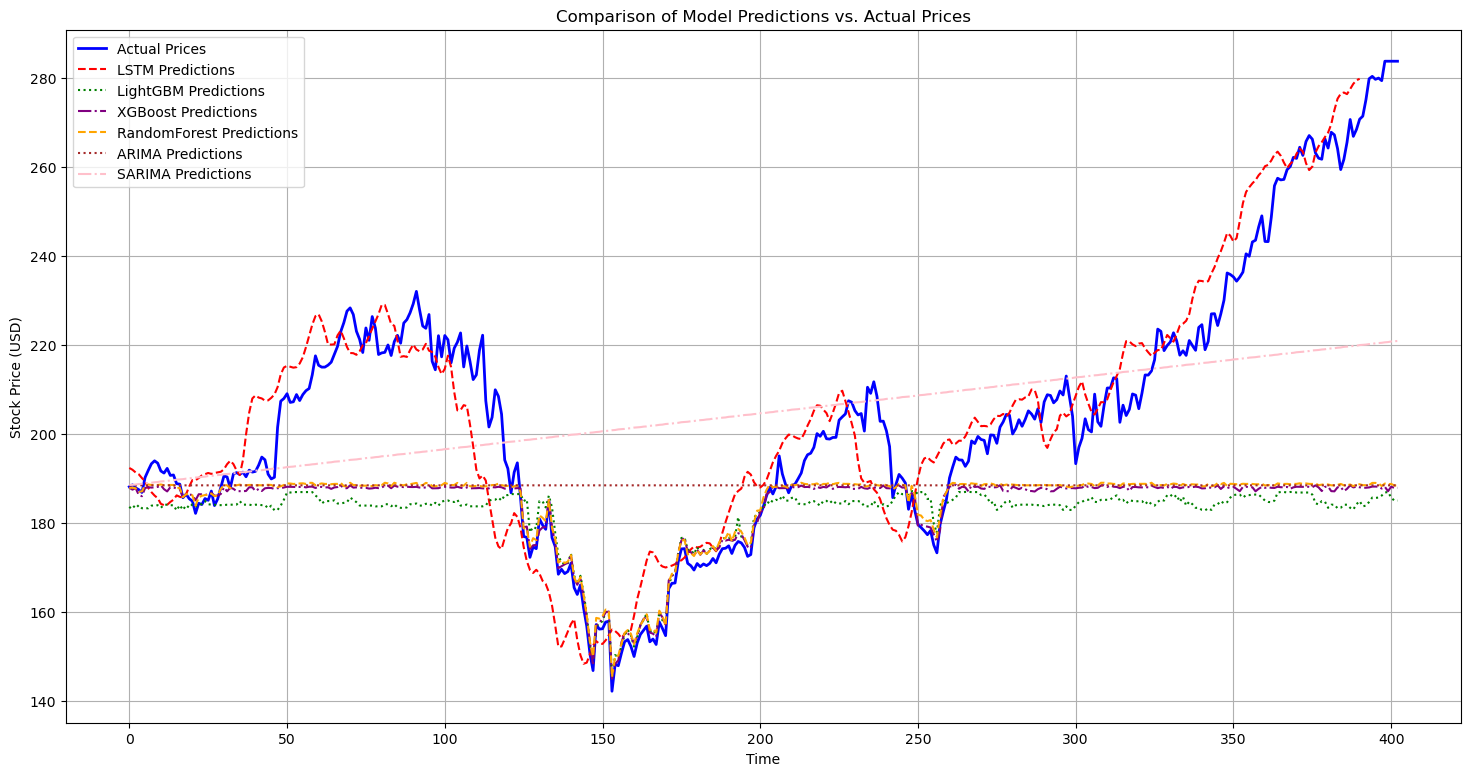

In [36]:
plt.figure(figsize=(18, 9))

plt.plot(y_test.values, label='Actual Prices', color='blue', linewidth=2)

plt.plot(test_predict, label='LSTM Predictions', color='red', linestyle='--')

plt.plot(lgb_model.predict(X_test), label='LightGBM Predictions', color='green', linestyle=':')

plt.plot(xgb_model.predict(dtest), label='XGBoost Predictions', color='purple', linestyle='-.')

plt.plot(rf_model.predict(X_test), label='RandomForest Predictions', color='orange', linestyle='--')

plt.plot(forecastArima.values, label='ARIMA Predictions', color='brown', linestyle=':')

plt.plot(forecastSarima.values, label='SARIMA Predictions', color='pink', linestyle='-.')

plt.title('Comparison of Model Predictions vs. Actual Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()